# Introduction to atomman: Defect Creation and Analysis

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.

Notebook last updated: 2018-04-05
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction

One of the focuses of the atomman package is to provide tools for generating and analyzing atomic systems containing defects.  Many of these tools are more complex than the basic tools outlined in the previous section. This Notebook provides an overview of the various defect capabilities in atomman.

**Library Imports**

In [1]:
# Standard Python libraries
from __future__ import (absolute_import, print_function,
                        division, unicode_literals)

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

atomman version = 1.2.0


## 2. Point defects

The atomman.defect.point() function inserts a point defect into a System and helps with tracking the defect by (1) moving any new/modified atoms to the end of the Atoms list and (2) adding per-atom property old_id that retains each atom's original index.

See [04.1. Point defects Jupyter Notebook](04.1. Point defects.ipynb) for more examples.

Parameters:

- __system__ (*atomman.System*) the system to add the defect to.

- __ptd_type__ (*str*) indicates which type of point defect to add.
    
    - ='v' -- vacancy
    
    - ='s' -- substitutional
    
    - ='i' -- positional interstitial
    
    - ='db' -- dumbbell interstitial

- __atype__ (*int, optional*) atom type for defect atom ('i', 's', 'db' styles).

- __pos__ (*array-like object, optional*) position for adding the defect atom (all styles).

- __ptd_id__ (*int, optional*) atom id where defect is added.  Alternative to using pos ('v', 's', 'db' styles).

- __db_vect__ (*array-like object, optional*) vector associated with the dumbbell interstitial ('db' style).

- __scale__ (*bool, optional*) indicates if pos and db_vect are absolute (False) or box-relative (True). Default is False.

- __atol__ (*float, optional*) absolute tolerance for position-based searching. Default is 1e-3 angstroms.

In [2]:
# Define 2x2x2 bcc demonstration supercell
a = uc.set_in_units(2.8665, 'angstrom')
box = am.Box(a=a, b=a, c=a)
atoms = am.Atoms(atype=1, pos=[[0.0,0.0,0.0], [0.5,0.5,0.5]])
ucell = am.System(atoms=atoms, box=box, scale=True)
system = ucell.supersize(2,2,2)
print(system.atoms_df())

    atype   pos[0]   pos[1]   pos[2]
0       1  0.00000  0.00000  0.00000
1       1  1.43325  1.43325  1.43325
2       1  2.86650  0.00000  0.00000
3       1  4.29975  1.43325  1.43325
4       1  0.00000  2.86650  0.00000
5       1  1.43325  4.29975  1.43325
6       1  2.86650  2.86650  0.00000
7       1  4.29975  4.29975  1.43325
8       1  0.00000  0.00000  2.86650
9       1  1.43325  1.43325  4.29975
10      1  2.86650  0.00000  2.86650
11      1  4.29975  1.43325  4.29975
12      1  0.00000  2.86650  2.86650
13      1  1.43325  4.29975  4.29975
14      1  2.86650  2.86650  2.86650
15      1  4.29975  4.29975  4.29975


In [3]:
# Change atom 5 into <111> dumbbell interstitial pair
defect_system = am.defect.point(system, 'db', ptd_id=5, db_vect=[0.3, 0.3, 0.3])
print(defect_system.atoms_df())

    atype   pos[0]   pos[1]   pos[2]  old_id
0       1  0.00000  0.00000  0.00000       0
1       1  1.43325  1.43325  1.43325       1
2       1  2.86650  0.00000  0.00000       2
3       1  4.29975  1.43325  1.43325       3
4       1  0.00000  2.86650  0.00000       4
5       1  2.86650  2.86650  0.00000       6
6       1  4.29975  4.29975  1.43325       7
7       1  0.00000  0.00000  2.86650       8
8       1  1.43325  1.43325  4.29975       9
9       1  2.86650  0.00000  2.86650      10
10      1  4.29975  1.43325  4.29975      11
11      1  0.00000  2.86650  2.86650      12
12      1  1.43325  4.29975  4.29975      13
13      1  2.86650  2.86650  2.86650      14
14      1  4.29975  4.29975  4.29975      15
15      1  1.13325  3.99975  1.13325       5
16      1  1.73325  4.59975  1.73325      16


## 3. Stroh method for dislocations

The atomman.Stroh class obtains a solution for the Eshelby anisotropic elasticity model of a perfectly straight dislocation using the Stroh method. 

See the [04.2. Stroh class Jupyter Notebook](04.2. Stroh class.ipynb) for more details on the methods and theory.

Parameters to initialize Stroh object

- **C** (*atomman.ElasticConstants*) The medium's elastic constants.

- **burgers** (*array-like object*) The dislocation's Cartesian Burgers vector.

- **axes** (*array-like object, optional*) 3x3 set of rotational axes for the system. If given, C and burgers will be transformed using axes.

- **m** (*array-like object, optional*) The m unit vector for the solution.  m, n, and u (dislocation line) should be right-hand orthogonal.  Default value is [1,0,0] (x-axis).

- **n** (*array-like object, optional*) The n unit vector for the solution.  m, n, and u (dislocation line) should be right-hand orthogonal.  Default value is [0,1,0] (y-axis).

- **tol** (*float*) Tolerance parameter used to round off near-zero values.  Default value is 1e-8.

### 3.1. Solve Stroh method for bcc iron a/2&lt;111&gt;{-101} edge dislocation. 

In [4]:
# Burgers vector
burgers = a * np.array([0.5, 0.5, 0.5])

# Elastic constants 
C11 = uc.set_in_units(240, 'GPa')
C12 = uc.set_in_units(145, 'GPa')
C44 = uc.set_in_units(115, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

# System orientation (using default m and n vectors)
x_axis = np.array([ 1, 1, 1]) # parallel to burgers (edge dislocation)
y_axis = np.array([-1, 0, 1]) # perpendicular to slip plane
z_axis = np.array([ 1,-2, 1]) # parallel to line direction
axes = np.array([x_axis, y_axis, z_axis])

# Get Stroh solution
stroh = am.defect.Stroh(C=C, burgers=burgers, axes=axes)

### 3.2. Use Stroh solution to insert dislocation into atomic system.

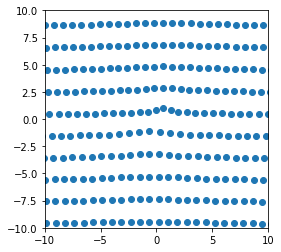

In [5]:
# Create bulk bcc system in proper orientation
disl_system = ucell.rotate(axes)
disl_system = disl_system.supersize((-3, 3), (-3, 3), 1)
disl_system.atoms.pos += a * np.array([0.00, 0.25, 0.00]) # shift pos so no y=0 coordinates

# Displace atomic positions by Stroh.displacement()
displacement = stroh.displacement(disl_system.atoms.pos)
disl_system.atoms.pos += displacement

# Plot x and y atomic coordinates to show dislocation
x = disl_system.atoms.pos[:, 0]
y = disl_system.atoms.pos[:, 1]

fig = plt.figure(figsize=(4,4))
plt.plot(x, y, 'o')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

## 4. Dislocation anaylsis tools

There are also a number of analysis tools for characterizing dislocations and other crystalline defects.

- **atomman.defect.slip_vector()** calculates the slip vector for all atoms in a system.  This is a good tool for characterizing plastic deformation within a system that occurs between two points in time. 

- **atomman.defect.disregistry()** characterizes a dislocation's planar spreading by calculating the relative displacement of atoms between the atomic planes above and below the dislocation's slip plane. 

- **atomman.defect.nye_tensor()** allows for dislocation cores to be characterized using the gradient of the deformation tensor.  Also calculates the strain state for all atoms in the system relative to a perfect crystal configuration.

- **atomman.defect.differential_displacement()** allows for dislocation cores to be characterized using the difference in the displacements between all pairs of neighbor atoms relative to a perfect crystal configuration.

See the [04.3. Dislocation analysis tools Jupyter Notebook](04.3. Dislocation analysis tools.ipynb) for the underlying theory and examples of the tools being used.

## 5. Semidiscrete variational Peierls-Nabarro dislocations

Classes and functions are included that allow for semidiscrete variational Peierls-Nabarro models of dislocations to be solved. 

See the [04.4. Semidiscrete Variational Peierls-Nabarro Jupyter Notebook](04.04 Semidiscrete Variational Peierls-Nabarro.ipynb) for a description of the method and examples. 